# Modèle SVM

Travail de reprise à terminer

In [15]:
# Installation et chargement des requirements
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [11]:
#Préparation des données pour les algorithmes de machine learning

##############################################################################
####  Définition de la variable cible et des attributs              #########
############################################################################

df = all_expenses_clean.copy()

# Variable cible : profil
y = df["profil"]

# Variables explicatives
X = df.drop([
    "TOTEXP23",
    "profil", "DUPERSID"
], axis=1, errors="ignore")



###############################################################################
#####    Création des échantillons test et train                        #######
###############################################################################

#On sépare les données en deux échantillons train et test

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,    # en cas de classification, cette option sert à conserver les mêmes prportions de chaque classe dans les échantillons d'entrainement et de test
    random_state=42 #utile pour la reproductibilité
)

n_samples, n_features = X_train.shape
print("L'échnatillon d'entrainement contient: {} individus et {} variables explicatives".format(n_samples, n_features))
print("L'échantillon test contient : {} individus".format(X_test.shape[0]))

L'échnatillon d'entrainement contient: 5698 individus et 128 variables explicatives
L'échantillon test contient : 1900 individus


In [13]:
#Nous créons un transformeur preprocess pour prétraiter les données

###############################################################################
############              Preprocessing                               #########
###############################################################################

# Séparation des variables numériques et catégorielles pour le pipeline
num_vars = X.select_dtypes(include=["int64", "float64"]).columns
cat_vars = X.select_dtypes(include=["object", "category"]).columns

###############################################################################
############   Preprocess classique sans log-transformation           #########
###############################################################################

# Les variables numériques correspondent à des variables de santé:
# nous choisissons donc d'attribuer la valeur 0 à leur valeurs manquantes
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    #on utilise la transformation  (x-median)/ intervalle interquartile pour
    #tenir compte de la distribution très asymétrique des données de sante
    ("scaler", RobustScaler())
])

# Il n'y a aucune valeur manquante parmi les variables catégorielles choisies
# ce qui rend l'imputation facultative
categorical_transformer = Pipeline(steps=[
    #("imputer", SimpleImputer(strategy="constant", fill_value="Not defined")),
#encodage des variables catégorielles sous forme d'indicatrices
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

#On assemble le prétatraitement des variables numériques et cétegorielles
#dans un preprocesseur unique
preproc = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_vars),
        ("cat", categorical_transformer, cat_vars)
    ]
)

###############################################################################
############   Preprocess2 avec  log-transformation                   #########
###############################################################################

# Nous séparons l'unique variable négative(tendance), des autres variables
# toutes positives avant d'appliquer la log-transformation
num_negative = ["tendance"]
num_positive = [col for col in num_vars if col not in num_negative]

log_transformer = FunctionTransformer(lambda x: np.log1p(x))

numeric_positive_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("log", log_transformer),
    ("scaler", StandardScaler())
])

numeric_negative_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preproc2 =  ColumnTransformer(
    transformers=[
        ("num_pos", numeric_positive_transformer, num_positive),
        ("num_neg", numeric_negative_transformer, num_negative),
        ("cat", categorical_transformer, cat_vars)
    ],
    remainder="drop"
)


###############################################################################
############   Preprocess3 pour les réseaux de neurones               #########
###############################################################################

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("scaler", StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess3 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_vars),
        ("cat", categorical_transformer, cat_vars)
    ]
)


## Premier modèle: régression logistique

In [ ]:
# Pipeline : Prétraitement + régression logistique

cols_to_remove = ["DUPERSID"]

pipe_logreg = Pipeline([
    ('preprocess', preproc),   # Utilisation du transformer preprocess créé au début de la section 3
    ('logreg', LogisticRegression(max_iter=5000, random_state=42)) #Entrainement du modèle sur les données transfomées
])


# Grille d’hyperparamètres pour la régression logistique
parameters_logreg = {
    'logreg__C': np.logspace(-8, 8, 17, base=2)
}

# Grid Search
clf_logreg = GridSearchCV(
    estimator=pipe_logreg,
    param_grid=parameters_logreg,
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1
)

# Entraînement
clf_logreg.fit(X_train, y_train)

# Résultats
print("=== Résultats régression logistique===")
print("Meilleur paramètre (C) :", clf_logreg.best_params_)
print("Accuracy moyenne CV :", clf_logreg.best_score_) #performance lors de la validation croisée
print("Accuracy sur test :", clf_logreg.score(X_test, y_test)) #Vraie performance du modèle sur des données qui n'ont jamais été vues ni lors de l'entrainement, ni lors de la validation croisée


=== Résultats régression logistique===
Meilleur paramètre (C) : {'logreg__C': np.float64(0.00390625)}
Accuracy moyenne CV : 0.3296555504383586
Accuracy sur test : 0.34046521834540266


In [ ]:
#Evaluation des performances du modèle

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
    top_k_accuracy_score
)

# Prédictions
y_pred = clf_logreg.predict(X_test)

print("\n=== Performances globales du modèle ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Balanced accuracy :", balanced_accuracy_score(y_test, y_pred))
print("Macro F1-score :", f1_score(y_test, y_pred, average="macro"))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== Confusion Matrix ===")

# Matrice de confusion brute
cm = confusion_matrix(y_test, y_pred)

# Matrice de confusion formatée avec labels explicites
cm_df = pd.DataFrame(
    cm,
    index=[f"Vrai {c}" for c in sorted(y_test.unique())],
    columns=[f"Prédit {c}" for c in sorted(y_test.unique())]
)

print(cm_df)



=== Performances globales du modèle ===
Accuracy : 0.49315789473684213
Balanced accuracy : 0.33925438596491225
Macro F1-score : 0.3051962964577974

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.80      0.52      0.63      1520
           1       0.16      0.47      0.24       304
           2       0.22      0.03      0.05        76

    accuracy                           0.49      1900
   macro avg       0.39      0.34      0.31      1900
weighted avg       0.68      0.49      0.55      1900


=== Confusion Matrix ===
        Prédit 0  Prédit 1  Prédit 2
Vrai 0       792       721         7
Vrai 1       161       143         0
Vrai 2        35        39         2


## 3.2 Deuxième modèle de classification: le modèle SVM

In [ ]:
# Pipeline : Prétraitement + SVM
pipe_svm = Pipeline([
    ('preprocess', preproc2),   # Utilisation du transformer preprocess créé au début de la section 3
    ('svc', LinearSVC(max_iter=5000, dual=False, random_state=42)) #Entrainement du modèle sur les données transfomées
])

# Grille d’hyperparamètres pour SVM
parameters_svm = {'svc__C': [0.01, 0.1, 1, 10, 100]}

# Grid Search
clf_svm = GridSearchCV(
    estimator=pipe_svm,
    param_grid=parameters_svm,
    cv=5,
  #  scoring="balanced_accuracy",
    n_jobs=-1 #utilise tous les CPU disponibles
)

# Entraînement
clf_svm.fit(X_train, y_train)

# Résultats
print("=== Résultats SVM ===")
print("Meilleur paramètre (C) :", clf_svm.best_params_)
print("Accuracy moyenne CV :", clf_svm.best_score_) #performance lors de la validation croisée
print("Accuracy sur test :", clf_svm.score(X_test, y_test)) #Vraie performance du modèle sur des données qui n'ont jamais été vues ni lors de l'entrainement, ni lors de la validation croisée


=== Résultats SVM ===
Meilleur paramètre (C) : {'svc__C': 0.01}
Accuracy moyenne CV : 0.7994031391032455
Accuracy sur test : 0.7994736842105263


In [ ]:
#Evaluation des performances du modèle

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
    top_k_accuracy_score
)

# Prédictions
y_pred = clf_svm.predict(X_test)

print("\n=== Performances globales du modèle ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Balanced accuracy :", balanced_accuracy_score(y_test, y_pred))
print("Macro F1-score :", f1_score(y_test, y_pred, average="macro"))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== Confusion Matrix ===")

# Matrice de confusion brute
cm = confusion_matrix(y_test, y_pred)

# Matrice de confusion formatée avec labels explicites
cm_df = pd.DataFrame(
    cm,
    index=[f"Vrai {c}" for c in sorted(y_test.unique())],
    columns=[f"Prédit {c}" for c in sorted(y_test.unique())]
)

print(cm_df)




=== Performances globales du modèle ===
Accuracy : 0.7994736842105263
Balanced accuracy : 0.3333333333333333
Macro F1-score : 0.2961879691917715

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1519
           1       0.00      0.00      0.00       209
           2       0.00      0.00      0.00       172

    accuracy                           0.80      1900
   macro avg       0.27      0.33      0.30      1900
weighted avg       0.64      0.80      0.71      1900


=== Confusion Matrix ===
        Prédit 0  Prédit 1  Prédit 2
Vrai 0      1519         0         0
Vrai 1       209         0         0
Vrai 2       172         0         0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 3.3 troisième modèle: Random Forest

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Pipeline : prétraitement + Random Forest
pipe_rf = Pipeline([
    ('preprocess', preproc),
    ('rf', RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])

# Grille d'hyperparamètres pour Random Forest
parameters_rf = {
    'rf__n_estimators': [200, 500],          # nombre d'arbres
    'rf__max_depth': [None, 10, 20],         # profondeur maximale
    'rf__min_samples_split': [2, 5, 10],     # min d'échantillons pour un split
    'rf__min_samples_leaf': [1, 2, 4],       # min d'échantillons par feuille
    'rf__max_features': ['sqrt', 'log2', 0.5]  # nombre de features testés par split
}

# Grid Search : recherche des hyperparamètres par validation croisée
clf_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=parameters_rf,
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1,
    error_score='raise'
)

# Entraînement
clf_rf.fit(X_train, y_train)

# Résultats
print("=== Résultats Random Forest ===")
print("Meilleurs paramètres :", clf_rf.best_params_)
print("Balanced Accuracy CV :", clf_rf.best_score_)
print("Accuracy test :", clf_rf.score(X_test, y_test))


KeyboardInterrupt: 

## Modèle 4 : XGBoost

In [ ]:
import warnings
warnings.filterwarnings("ignore")


# Encodage des labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Vérification des classes
print("Classes encodées :", np.unique(y_train_enc))

# Pipeline
pipe_xgb = Pipeline([
    ('preprocess', preproc),
    ('xgb', XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        eval_metric='mlogloss',
        random_state=42,
        tree_method="hist",
        n_jobs=-1
    ))
])

# Grille
parameters_xgb = {
    'xgb__n_estimators': [200, 500],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0]
}

# Grid Search
clf_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=parameters_xgb,
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1,
    error_score="raise"
)

# Entraînement
clf_xgb.fit(X_train, y_train_enc)

# Résultats
print("=== Résultats XGBoost ===")
print("Meilleurs paramètres :", clf_xgb.best_params_)
print("Balanced Accuracy CV :", clf_xgb.best_score_)
print("Accuracy test :", clf_xgb.score(X_test, y_test_enc))


KeyboardInterrupt: 

## 3.5 Réseau de neurones / Multilayer Perceptron (MLP)

In [ ]:
from tqdm.notebook import tqdm


# Création d'un module PyTorch qui représente un modèle.
# input_size : nombre de features en entrée
# hidden_sizes : tailles des couches cachées (2 couches : 128 puis 64 neurones)
# output_size : nombre de classes à prédire (par défaut 3)

###############################################################################
###   Préparation des données pour Pythorch                                ###
##############################################################################

class SimpleFeedForward(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64], output_size=3):
        super().__init__()
      #Définition de l'architecture du réseau
      # Linear → ReLU → Linear → ReLU → Linear
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], output_size)
        )

    def forward(self, x):
        return self.classifier(x)

# Le modèle apprend les paramètres utiles aux transformations (médiane,
# écart_interquartile...) sur le train uniquement, ces données seront utilisées
# à l'étape suivante
preprocess3.fit(X_train)

# Transformation des données avec le preprocessing
X_train_t = preprocess3.transform(X_train)
X_test_t  = preprocess3.transform(X_test)

# Conversion en tenseurs
X_train_tensor = torch.tensor(X_train_t, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_t, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.long)

# DataLoader (générateur de mini-batch)
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds  = TensorDataset(X_test_tensor, y_test_tensor)

trainloader = DataLoader(train_ds, batch_size=64, shuffle=True)
valloader  = DataLoader(test_ds, batch_size=64)

###############################################################################
###                      Boucle d'entrainement                              ###
##############################################################################

def train(model, trainloader, loss_fn, optimizer, epoch, num_epochs):
    model.train()
    loop = tqdm(trainloader, desc=f"Training Epoch [{epoch+1}/{num_epochs}]")

    for inputs, targets in loop:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()


# ============================================================
# 3. Initialisation du modèle, de la loss et de l’optimiseur
# ============================================================

input_size = X_train_t.shape[1]   # Nombre de colonnes après preprocessing
output_size = 3                   # Classes du profil (0/1/2)
hidden_sizes = [128, 64]
lr = 1e-3
num_epochs = 20

net = SimpleFeedForward(input_size, hidden_sizes, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)



###############################################################################
###                     Validation du modèle                               ###
##############################################################################

def validation(model, valloader, loss_fn):
    model.eval()
    total = 0
    running_loss = 0.0
    accuracy = 0.0

    with torch.no_grad():
        loop = tqdm(valloader, desc="Validation")

        for inputs, targets in loop:
            outputs = model(inputs)

            batch_size = inputs.shape[0]
            total += batch_size

            running_loss += batch_size * loss_fn(outputs, targets).item()
            accuracy += (outputs.argmax(dim=1) == targets).sum().item()

            loop.set_postfix(
                val_loss=running_loss / total,
                val_acc=accuracy / total
            )

    return running_loss / total, accuracy / total

###############################################################################
###                     Entrainement du modèle                              ###
##############################################################################

input_size = X_train_t.shape[1]   # nb de colonnes après preprocess
model = SimpleFeedForward(input_size=input_size, hidden_sizes=[128, 64], output_size=3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20

for epoch in range(num_epochs):
    train(model, trainloader, criterion, optimizer, epoch, num_epochs)
    val_loss, val_acc = validation(model, valloader, criterion)

# ============================================================
# 5. Boucle d'entraînement sur le dataset de santé
# ============================================================

for epoch in range(num_epochs):

    train(net, trainloader, criterion, optimizer, epoch, num_epochs)

    val_loss, val_acc = validation(net, valloader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs} - Validation loss: {val_loss:.4f} - acc: {val_acc:.4f}")

# ============================================================
# 6. Évaluation finale sur le jeu de test (jamais vu)
# ============================================================

test_loss, test_acc = validation(net, valloader, criterion)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")




Training Epoch [1/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [2/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [3/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [4/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [5/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [6/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [7/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [8/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [9/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [10/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [11/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [12/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [13/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [14/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [15/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [16/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [17/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [18/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [19/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [20/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch [1/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/20 - Validation loss: 1.1688 - acc: 0.1279


Training Epoch [2/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/20 - Validation loss: 1.1688 - acc: 0.1279


Training Epoch [3/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/20 - Validation loss: 1.1688 - acc: 0.1279


Training Epoch [4/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/20 - Validation loss: 1.1688 - acc: 0.1279


Training Epoch [5/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/20 - Validation loss: 1.1688 - acc: 0.1279


Training Epoch [6/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6/20 - Validation loss: 1.1688 - acc: 0.1279


Training Epoch [7/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7/20 - Validation loss: 1.1688 - acc: 0.1279


Training Epoch [8/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8/20 - Validation loss: 1.1688 - acc: 0.1279


Training Epoch [9/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9/20 - Validation loss: 1.1688 - acc: 0.1279


Training Epoch [10/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/20 - Validation loss: 1.1688 - acc: 0.1279


Training Epoch [11/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 11/20 - Validation loss: 1.1688 - acc: 0.1279


Training Epoch [12/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 12/20 - Validation loss: 1.1688 - acc: 0.1279


Training Epoch [13/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 13/20 - Validation loss: 1.1688 - acc: 0.1279


Training Epoch [14/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 14/20 - Validation loss: 1.1688 - acc: 0.1279


Training Epoch [15/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 15/20 - Validation loss: 1.1688 - acc: 0.1279


Training Epoch [16/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 16/20 - Validation loss: 1.1688 - acc: 0.1279


Training Epoch [17/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 17/20 - Validation loss: 1.1688 - acc: 0.1279


Training Epoch [18/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 18/20 - Validation loss: 1.1688 - acc: 0.1279


Training Epoch [19/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 19/20 - Validation loss: 1.1688 - acc: 0.1279


Training Epoch [20/20]:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 20/20 - Validation loss: 1.1688 - acc: 0.1279


Validation:   0%|          | 0/30 [00:00<?, ?it/s]

Test accuracy: 0.1279 | Test loss: 1.1688


In [ ]:
X_train_t.max(), X_train_t.min(), np.isnan(X_train_t).sum()


(np.float64(1.976961168052253e+17),
 np.float64(-3.716647323269057e+17),
 np.int64(0))

/tmp/ipython-input-3821498107.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dep_age = all_expenses_clean.groupby("age_class")["TOTEXP22"].sum()


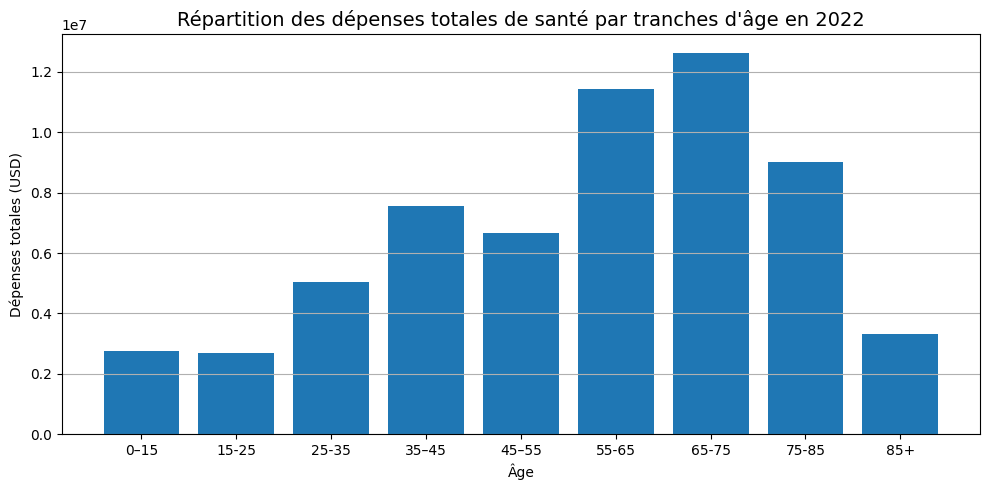

In [ ]:
# Création des classes d'âge
bins = [0, 15, 25, 35, 45,55, 65,75,85,  120]  # limites
labels = ["0–15","15-25","25-35", "35–45", "45–55","55-65","65-75", "75-85", "85+"]  # noms des classes

all_expenses_clean["age_class"] = pd.cut(
    all_expenses_clean["AGE22X"],
    bins=bins,
    labels=labels,
    right=False  # intervalle fermé à gauche [ )
)

dep_age = all_expenses_clean.groupby("age_class")["TOTEXP22"].sum()

plt.figure(figsize=(10,5))
plt.bar(dep_age.index, dep_age.values)

plt.title("Répartition des dépenses totales de santé par tranches d'âge en 2022", fontsize=14)
plt.xlabel("Âge")
plt.ylabel("Dépenses totales (USD)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
Chaque étape de ta boucle fait :

Calcul de la perte

Calcul des gradients (backprop)

Mise à jour des poids

Et recommence sur un nouveau mini-batch

L(θ)=−logpθ​(y∣x)

θ=θ−η⋅∂L​/ ∂θ

Les réseaux de neurones détestent :

les variables catégorielles encodées en one-hot → sparse high-dim

les distributions très asymétriques

les très fortes colinéarités

les dizaines de variables sans relation linéaire

les effets d’interaction complexes

Ton dataset, typique des dépenses de santé, contient :

variables médicales asymétriques

beaucoup de zéros

beaucoup de valeurs extrêmes

des colonnes fortement corrélées

des variables catégorielles encodées large

➡️ RandomForest / XGBoost écrasent les MLP en tabulaire.

Les MLP ne brillent que dans :

vision

audio

texte

grandes bases continues propres

SyntaxError: unterminated string literal (detected at line 1) (ipython-input-3107015130.py, line 1)